Download TSLA data from [yahoo](https://finance.yahoo.com/quote/TSLA/history?p=TSLA)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Semon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading

In [3]:
# ticker_df_path = 'data/DOGE-USD.csv'
# ticker_df_path = 'data/BTC-USD.csv'
ticker_df_path = 'data/TSLA.csv'
# ticker_df_path = 'data/CNY=X.csv'

tweets_df_path = 'data/elon_prepared_tweets.csv'
# tweets_df_path = 'data/trump_prepared_tweets.csv'

In [4]:
ticker_df = pd.read_csv(ticker_df_path)
ticker_df.Date = pd.to_datetime(ticker_df.Date)
ticker_df.set_index('Date', drop=True, inplace=True)
ticker_df['NextDayClose'] = ticker_df.Close.shift(-1)
ticker_df = ticker_df.reindex(
    pd.date_range(
        '2019-01-01', 
        ticker_df.index.max()
    ),
    method='backfill',
)
ticker_df.head()

,Open,High,Low,Close,Adj Close,Volume,NextDayClose
2019-01-01,61.220001,63.026001,59.759998,62.023998,62.023998,58293000,60.071999
2019-01-02,61.220001,63.026001,59.759998,62.023998,62.023998,58293000,60.071999
2019-01-03,61.400002,61.880001,59.476002,60.071999,60.071999,34826000,63.537998
2019-01-04,61.200001,63.599998,60.546001,63.537998,63.537998,36970500,66.991997
2019-01-05,64.344002,67.348000,63.549999,66.991997,66.991997,37756000,67.070000


In [5]:
ticker_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1320 entries, 2019-01-01 to 2022-08-12
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1320 non-null   float64
 1   High          1320 non-null   float64
 2   Low           1320 non-null   float64
 3   Close         1320 non-null   float64
 4   Adj Close     1320 non-null   float64
 5   Volume        1320 non-null   int64  
 6   NextDayClose  1319 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.5 KB


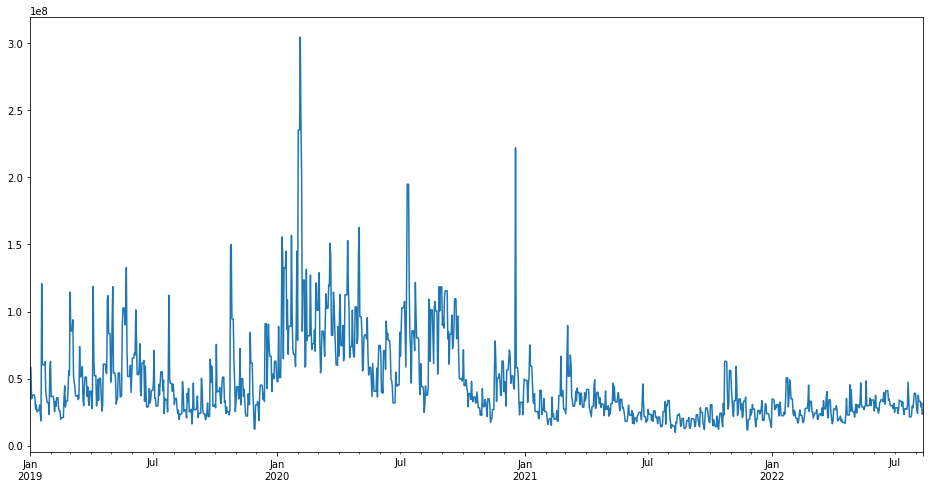

In [6]:
ticker_df.Volume.plot(figsize=(16, 8));

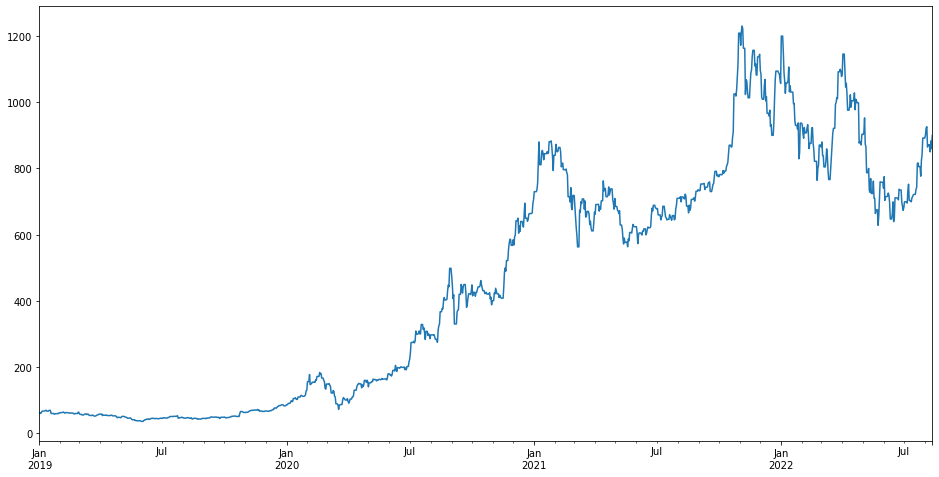

In [7]:
ticker_df.Close.plot(figsize=(16, 8));

In [8]:
tweets_df = pd.read_csv(tweets_df_path, index_col='id', parse_dates=['date'])
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,-0.048342,-0.014244,0.016088,0.002211,-0.012234,0.082633,-0.016118,...,-0.000773,-0.019107,-0.039366,0.015982,0.049104,-0.056251,-0.057072,-0.057435,-0.011789,0.036748
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.012730,-0.017078,0.028585,0.025572,-0.045578,0.065623,-0.013617,...,-0.012550,-0.046741,-0.000691,0.019577,0.077184,-0.057226,-0.047901,0.028700,0.011547,0.033419
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,-0.042071,-0.075559,-0.029521,0.020394,-0.014714,0.073634,-0.013487,...,-0.022040,-0.001922,-0.011946,0.028490,0.086696,-0.028041,-0.038507,-0.005319,0.075069,-0.058273
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.026122,-0.068418,0.031035,-0.038473,-0.031547,0.080213,-0.034022,...,0.003521,-0.032675,-0.035726,-0.006440,0.051075,-0.005771,-0.002485,-0.073661,-0.000422,0.012104
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,-0.061854,-0.111202,0.020066,0.037324,-0.120143,0.163722,-0.013768,...,0.025169,-0.046883,-0.015783,0.062415,0.068658,-0.104441,-0.167005,0.059559,0.263472,0.011272


In [9]:
# tweets_df = tweets_df[tweets_df.cleared_text.str.contains('doge')]

In [10]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8643 entries, 1211071324518531072 to 1344810193952014336
Columns: 303 entries, text to V300
dtypes: datetime64[ns](1), float64(300), object(2)
memory usage: 20.0+ MB


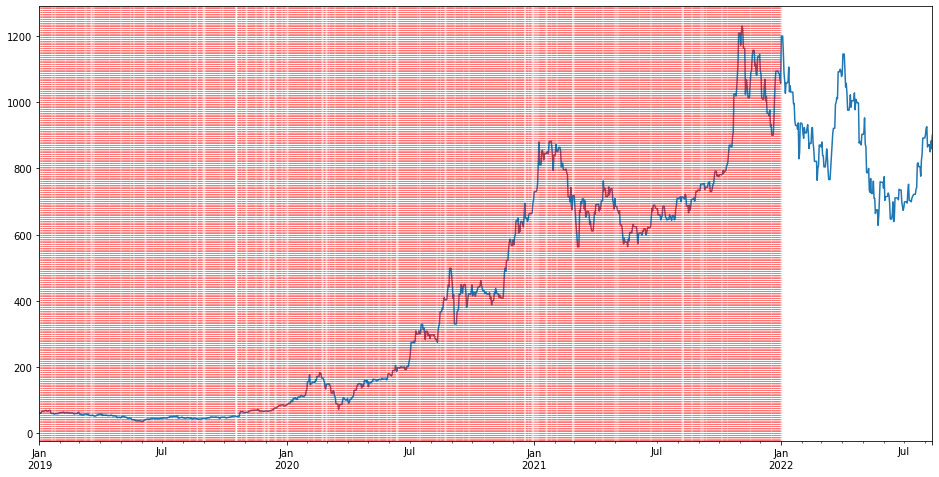

In [11]:
ticker_df.Close.plot(figsize=(16, 8));
for xc in set(tweets_df.date): # [tweets_df.cleared_text.str.contains('doge')]
    plt.axvline(x=xc, color='red', dashes=(0.2, 1))

In [12]:
tweets_df['ticker_grow_in_this_day'] = tweets_df.apply(
    lambda r: ticker_df.loc[r['date']], 
    axis=1
).apply(
    lambda r: np.int32(r.Open > r.NextDayClose), 
    axis=1
)

In [13]:
tweets_df['ticker_grow_in_this_day'].mean()

0.4246210806432952

In [14]:
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V292,V293,V294,V295,V296,V297,V298,V299,V300,ticker_grow_in_this_day
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,-0.048342,-0.014244,0.016088,0.002211,-0.012234,0.082633,-0.016118,...,-0.019107,-0.039366,0.015982,0.049104,-0.056251,-0.057072,-0.057435,-0.011789,0.036748,1
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.012730,-0.017078,0.028585,0.025572,-0.045578,0.065623,-0.013617,...,-0.046741,-0.000691,0.019577,0.077184,-0.057226,-0.047901,0.028700,0.011547,0.033419,1
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,-0.042071,-0.075559,-0.029521,0.020394,-0.014714,0.073634,-0.013487,...,-0.001922,-0.011946,0.028490,0.086696,-0.028041,-0.038507,-0.005319,0.075069,-0.058273,1
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.026122,-0.068418,0.031035,-0.038473,-0.031547,0.080213,-0.034022,...,-0.032675,-0.035726,-0.006440,0.051075,-0.005771,-0.002485,-0.073661,-0.000422,0.012104,1
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,-0.061854,-0.111202,0.020066,0.037324,-0.120143,0.163722,-0.013768,...,-0.046883,-0.015783,0.062415,0.068658,-0.104441,-0.167005,0.059559,0.263472,0.011272,1


In [15]:
words_on_grow_df = pd.DataFrame({
    'words': tweets_df.cleared_text.str.split().apply(set),
    'ticker_grow_in_this_day': tweets_df.ticker_grow_in_this_day,
}).explode('words')

words_in_tweets = pd.DataFrame({
    'tweets_ratio': words_on_grow_df.groupby('words')['ticker_grow_in_this_day'].count() / len(tweets_df),
    'tweets_grow_ratio': (
        words_on_grow_df.query('ticker_grow_in_this_day == 1').groupby('words')['ticker_grow_in_this_day'].count() 
        / len(tweets_df.query('ticker_grow_in_this_day == 1'))
    ),
    'tweets_fall_ratio': (
        words_on_grow_df.query('ticker_grow_in_this_day == 0').groupby('words')['ticker_grow_in_this_day'].count() 
        / len(tweets_df.query('ticker_grow_in_this_day == 0'))
    ),
}).fillna(0).query('tweets_ratio > 0.001')
words_in_tweets['grow_delta'] = (words_in_tweets.tweets_grow_ratio - words_in_tweets.tweets_ratio) / words_in_tweets.tweets_ratio
words_in_tweets['fall_delta'] = (words_in_tweets.tweets_fall_ratio - words_in_tweets.tweets_ratio) / words_in_tweets.tweets_ratio

In [16]:
words_in_tweets.sort_values(by='grow_delta', ascending=False).head(10)

,tweets_ratio,tweets_grow_ratio,tweets_fall_ratio,grow_delta,fall_delta
words,,,,,
timing,0.001041,0.002452,0.000000,1.355041,-1.000000
june,0.001041,0.002180,0.000201,1.093370,-0.806891
successful,0.001388,0.002725,0.000402,0.962534,-0.710336
enhanced,0.001157,0.002180,0.000402,0.884033,-0.652403
care,0.002198,0.004087,0.000804,0.859243,-0.634108
combustion,0.002661,0.004905,0.001005,0.843075,-0.622177
fiber,0.001041,0.001907,0.000402,0.831698,-0.613781
march,0.001041,0.001907,0.000402,0.831698,-0.613781
updates,0.001041,0.001907,0.000402,0.831698,-0.613781


In [17]:
words_in_tweets.sort_values(by='fall_delta', ascending=False).head(10)

,tweets_ratio,tweets_grow_ratio,tweets_fall_ratio,grow_delta,fall_delta
words,,,,,
final,0.001967,0.000272,0.003217,-0.861468,0.635751
august,0.001504,0.000272,0.002413,-0.818843,0.604294
versions,0.001273,0.000272,0.002011,-0.785905,0.579986
output,0.001273,0.000272,0.002011,-0.785905,0.579986
fees,0.001157,0.000272,0.001810,-0.764496,0.564187
nor,0.001157,0.000272,0.001810,-0.764496,0.564187
weren,0.001157,0.000272,0.001810,-0.764496,0.564187
guess,0.002198,0.000545,0.003418,-0.752101,0.555039
spent,0.001041,0.000272,0.001609,-0.738329,0.544876


## TF-IDF. Logistic regression

In [18]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=500,
)

In [19]:
X = tfidf_vectorizer.fit_transform(tweets_df.cleared_text).toarray()
y = tweets_df.ticker_grow_in_this_day

len(tfidf_vectorizer.vocabulary_)

500

In [20]:
train_percent = 0.8
idx = int(train_percent * len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7778, 500), (865, 500), (7778,), (865,))

In [21]:
rnd = np.random.default_rng(42)

y_baseline = np.int32(rnd.random(y_test.shape) <= y.mean())
print('Test classification report (baseline):\n')
print(classification_report(y_true=y_test, y_pred=y_baseline))

Test classification report (baseline):

              precision    recall  f1-score   support

           0       0.56      0.56      0.56       498
           1       0.41      0.40      0.40       367

    accuracy                           0.50       865
   macro avg       0.48      0.48      0.48       865
weighted avg       0.50      0.50      0.50       865



In [22]:
%%time
lin_regr = LogisticRegressionCV(
    cv=5,
    max_iter=5000,
    random_state=42,
    # scoring=lambda y_true, y_pred, *args: precision_score(1 - y_true, 1 - y_pred, *args),
    # scoring='precision',
    # class_weight='balanced',
    # multi_class='ovr',
).fit(X_train, y_train)

CPU times: total: 27.3 s
Wall time: 6.24 s


In [23]:
y_train_pred = lin_regr.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      4475
           1       1.00      0.00      0.00      3303

    accuracy                           0.58      7778
   macro avg       0.79      0.50      0.37      7778
weighted avg       0.76      0.58      0.42      7778



In [24]:
y_pred = lin_regr.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       498
           1       0.00      0.00      0.00       367

    accuracy                           0.58       865
   macro avg       0.29      0.50      0.37       865
weighted avg       0.33      0.58      0.42       865



C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [25]:
words_coeffs = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    lin_regr.coef_.flatten()
)))

In [26]:
lin_regr.intercept_

array([-0.29996225])

In [27]:
words_coeffs.sort_values(ascending=False).head(15)

cybertruck     0.284826
yup            0.228100
next           0.225277
mars           0.213514
idea           0.209308
model          0.206289
new            0.203816
sounds         0.193985
doge           0.188123
coming         0.168064
maybe          0.159998
interesting    0.155821
long           0.153871
faster         0.153496
launch         0.151731
dtype: float64

In [28]:
words_coeffs.sort_values(ascending=True).head(15)

right      -0.311185
ok         -0.261120
way        -0.213143
exactly    -0.198542
indeed     -0.178443
hope       -0.160733
sorry      -0.159230
yet        -0.154436
hard       -0.153561
still      -0.150873
great      -0.150068
soon       -0.145921
accurate   -0.139715
reality    -0.136147
know       -0.134153
dtype: float64

## TF-IDF. Random forest

In [29]:
random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [30]:
y_train_pred = random_forest.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      4475
           1       0.93      0.69      0.79      3303

    accuracy                           0.84      7778
   macro avg       0.87      0.82      0.83      7778
weighted avg       0.86      0.84      0.84      7778



In [31]:
y_pred = random_forest.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       498
           1       0.47      0.26      0.34       367

    accuracy                           0.56       865
   macro avg       0.53      0.52      0.50       865
weighted avg       0.54      0.56      0.53       865



In [32]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [33]:
%%time
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: total: 9.5 s
Wall time: 3min 2s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [34]:
y_train_pred = CV_rfc.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      4475
           1       1.00      0.00      0.00      3303

    accuracy                           0.58      7778
   macro avg       0.79      0.50      0.37      7778
weighted avg       0.76      0.58      0.42      7778



In [35]:
y_pred = CV_rfc.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       498
           1       0.00      0.00      0.00       367

    accuracy                           0.58       865
   macro avg       0.29      0.50      0.37       865
weighted avg       0.33      0.58      0.42       865



C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Semon\Desktop\OTUSFinalProject\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [36]:
words_importances = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    CV_rfc.best_estimator_.feature_importances_
)))

In [37]:
words_importances.sort_values(ascending=False).head(15)

cybertruck    0.022574
right         0.020722
density       0.016068
model         0.015807
way           0.014700
looks         0.011151
doge          0.010650
reality       0.010591
long          0.010331
time          0.010207
next          0.010015
idea          0.009830
indeed        0.009397
month         0.009376
mars          0.009336
dtype: float64

In [38]:
words_importances.sort_values(ascending=True).head(15)

person             0.000000
become             0.000002
good point         0.000004
absolutely         0.000024
30                 0.000059
million            0.000077
nice               0.000083
gas                0.000084
bit                0.000088
satellites         0.000095
half               0.000097
automatically      0.000099
flaps              0.000111
required           0.000113
congratulations    0.000124
dtype: float64